# Exploratory Data Analisys
First, we will start doing some exploratory analisys and visualitation over the data.
EDA will help us know and understand our data.

In [1]:
import pandas as pd
import numpy as np
import math
from numpy import nan
import seaborn as sns
import matplotlib as plt
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
import wget
url="http://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip"
wget.download(url) 

'household_power_consumption (2).zip'

In [3]:
import zipfile
with zipfile.ZipFile("household_power_consumption.zip", "r") as zf:
    zf.extractall()

# Data Cleansing
fill_missing() replaces NaN values for the value of the previous day

In [4]:
def fill_missing(values):
    one_day =  24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
            if np.isnan(values[row, col]):
                values[row, col] = values[row - one_day, col]

In [5]:
power_consumption=pd.read_csv('household_power_consumption.txt',sep=';',low_memory=False,infer_datetime_format=True,parse_dates={'datetime':[0,1]},index_col=['datetime'])
power_consumption=power_consumption[['Global_active_power']]
power_consumption.replace('?', nan, inplace=True)
power_consumption['Global_active_power'] = power_consumption['Global_active_power'].astype(float)
fill_missing(power_consumption.values)
power_consumption['Global_active_power'] = power_consumption['Global_active_power'].apply(lambda x: x/60)
power_consumption=power_consumption.resample('h').sum()
power_consumption.rename(columns={"Global_active_power":"Active_Energy"},inplace=True)

In [6]:
power_consumption.describe()

,Active_Energy
count,34589.000000
mean,1.088698
std,0.894659
min,0.046733
25%,0.342033
50%,0.804367
75%,1.574967
max,6.560533


# Data Visualitation

Naturally, the first thing we do is plot the time series.

<AxesSubplot:xlabel='datetime', ylabel='Active_Energy'>

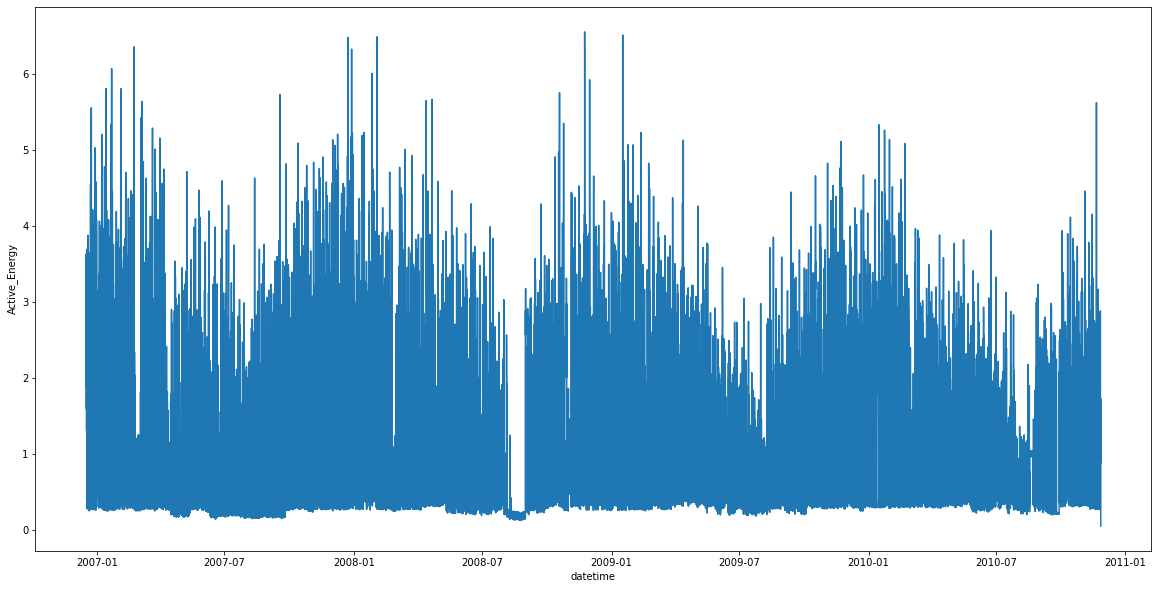

In [7]:
sns.lineplot(x=power_consumption.index,y='Active_Energy',data=power_consumption)

<AxesSubplot:xlabel='datetime'>

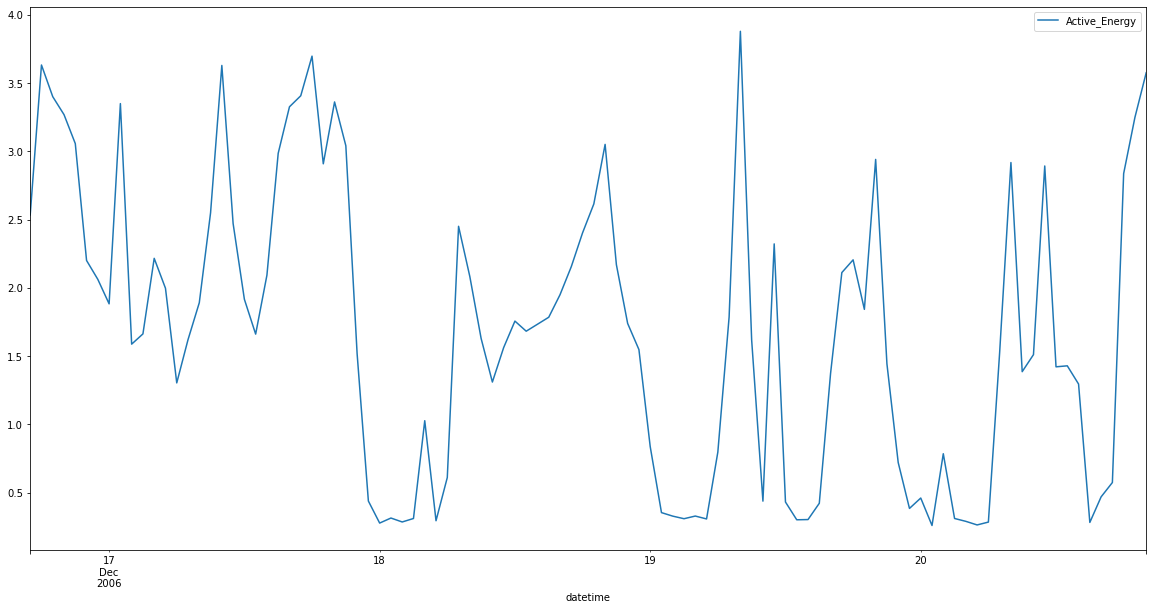

In [8]:
cut=100
zoom_data=power_consumption[:cut]
zoom_data.plot()

Then, we plot the histogram to get an idea of how our data is distributed.

array([[<AxesSubplot:title={'center':'Active_Energy'}>]], dtype=object)

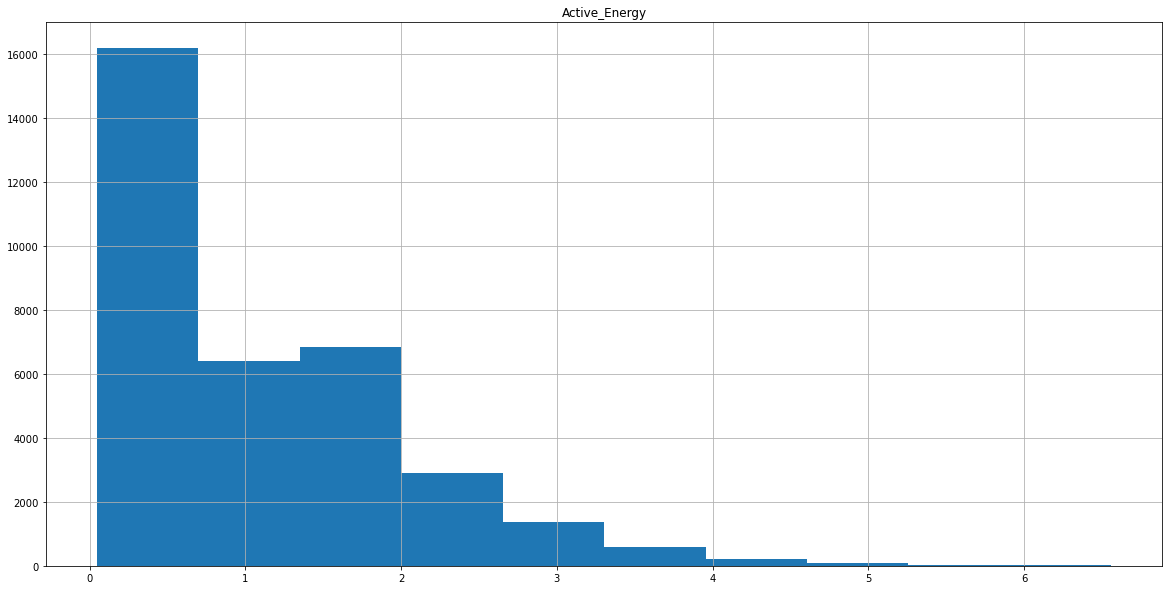

In [9]:
power_consumption.hist(column='Active_Energy')

Now, we descompose the time series into: trend, seasonal and residual components.
We don't see a notorius increasing trend, so we can suposse that an additive model will be better than a multiplicative one.
One the other hand, we can see a sort of seasonality with 8760 frequency (1 year)

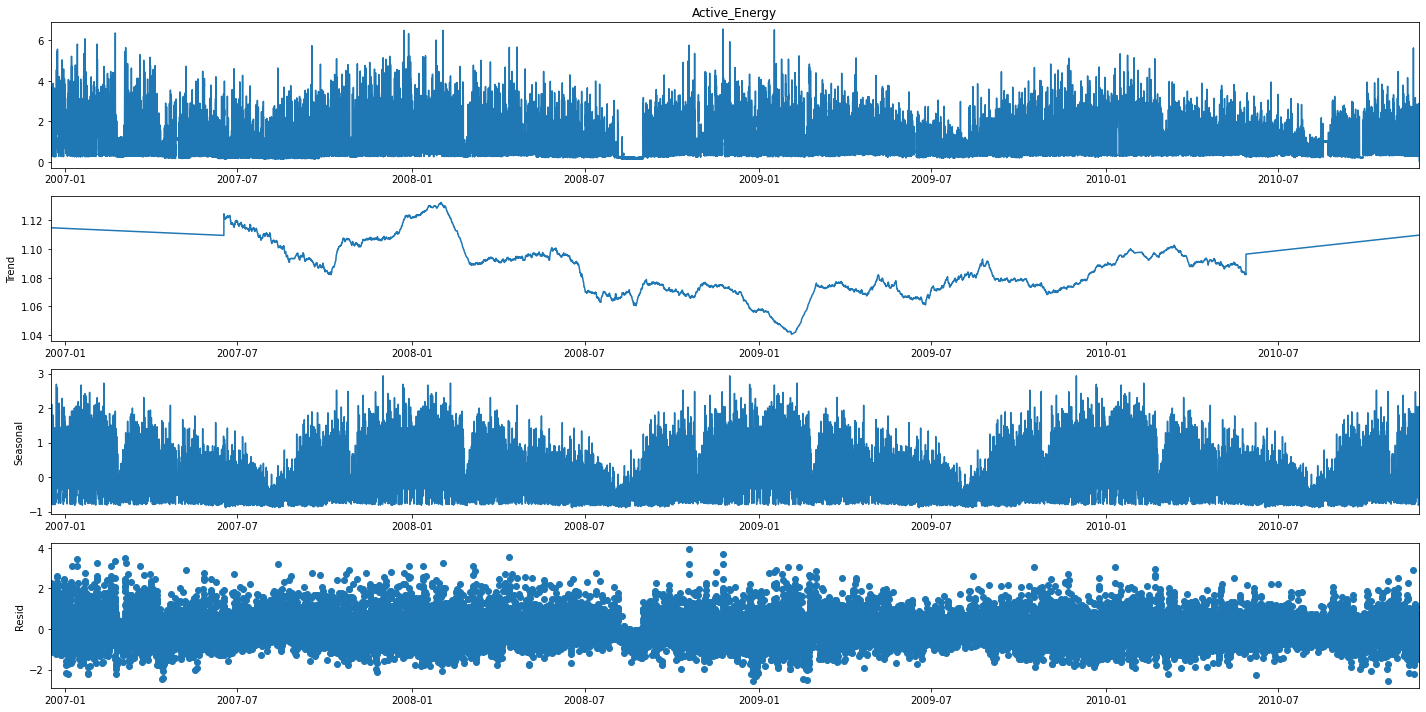

In [10]:
decomposition = seasonal_decompose(power_consumption['Active_Energy'], model='additive',period=8760, extrapolate_trend='freq')
decomposition.plot()
pyplot.show()

We can appreciatte that there is no significant trend. Also, we can see that the seasonal component changes a long the time, following a seasonal pattern , which may mean there is more than one seasonal pattern.

Now, we will plot the data changing the time series sampling frequency.

<AxesSubplot:xlabel='datetime', ylabel='Active_Energy'>

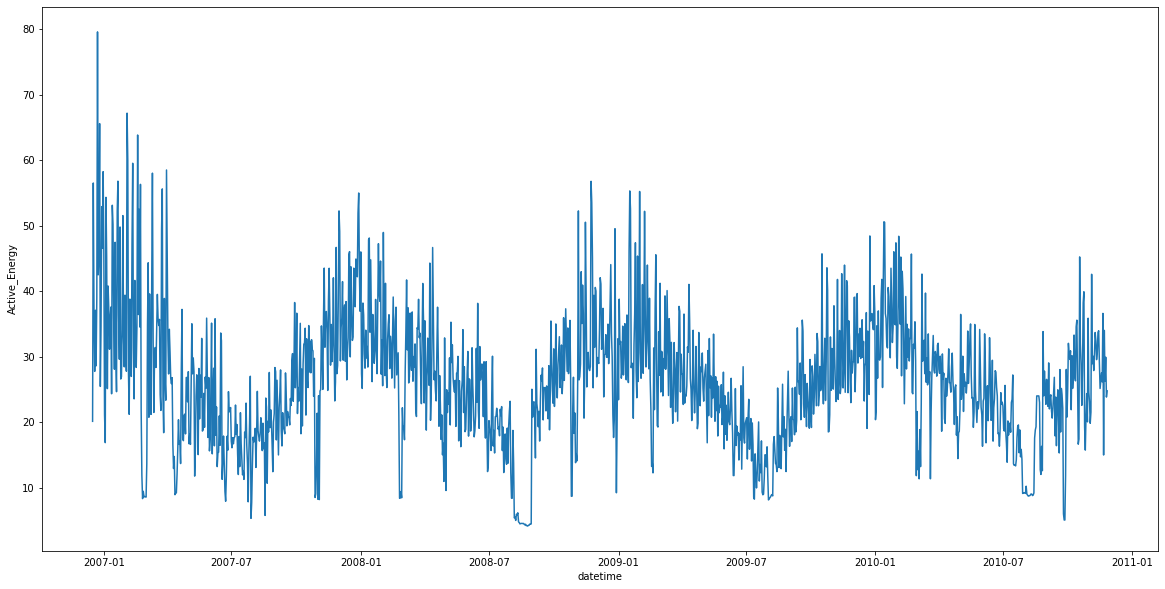

In [11]:
df_by_day=power_consumption.resample('D').sum()
sns.lineplot(x=df_by_day.index,y='Active_Energy',data=df_by_day)

<AxesSubplot:xlabel='datetime', ylabel='Active_Energy'>

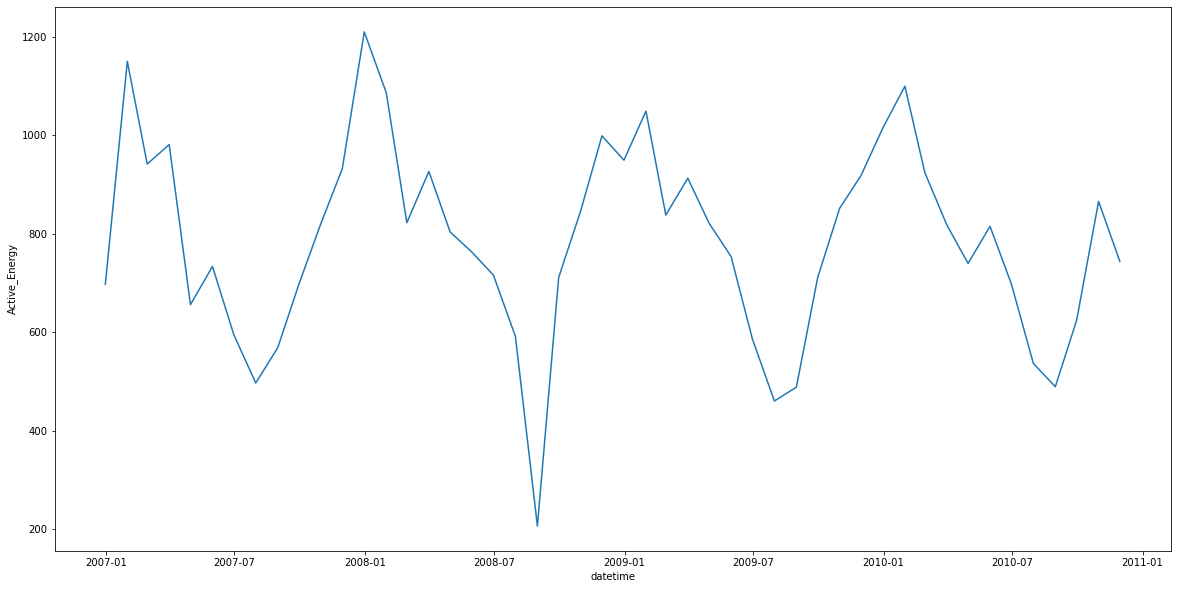

In [12]:
df_by_day=power_consumption.resample('M').sum()
sns.lineplot(x=df_by_day.index,y='Active_Energy',data=df_by_day)

As expected, we can see a seasonal yearly pattern.

Now, we are going to plot the average energy consumption by hour and month.

<AxesSubplot:xlabel='Hour', ylabel='Active_Energy'>

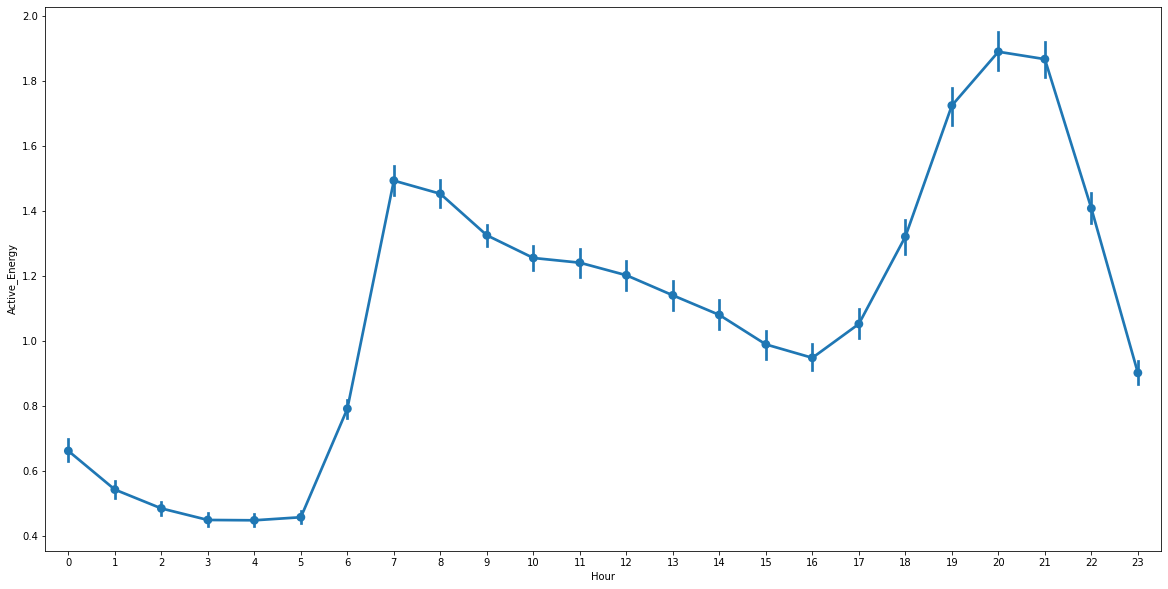

In [13]:
plot_for_power_consumption=power_consumption.copy()
plot_for_power_consumption['Hour']=plot_for_power_consumption.index.hour
plot_for_power_consumption['Month']=plot_for_power_consumption.index.month
sns.pointplot(data=plot_for_power_consumption,x='Hour',y='Active_Energy')

We can appreciate another seasonal pattern, but in that case is a dailly pattern.

<AxesSubplot:xlabel='Month', ylabel='Active_Energy'>

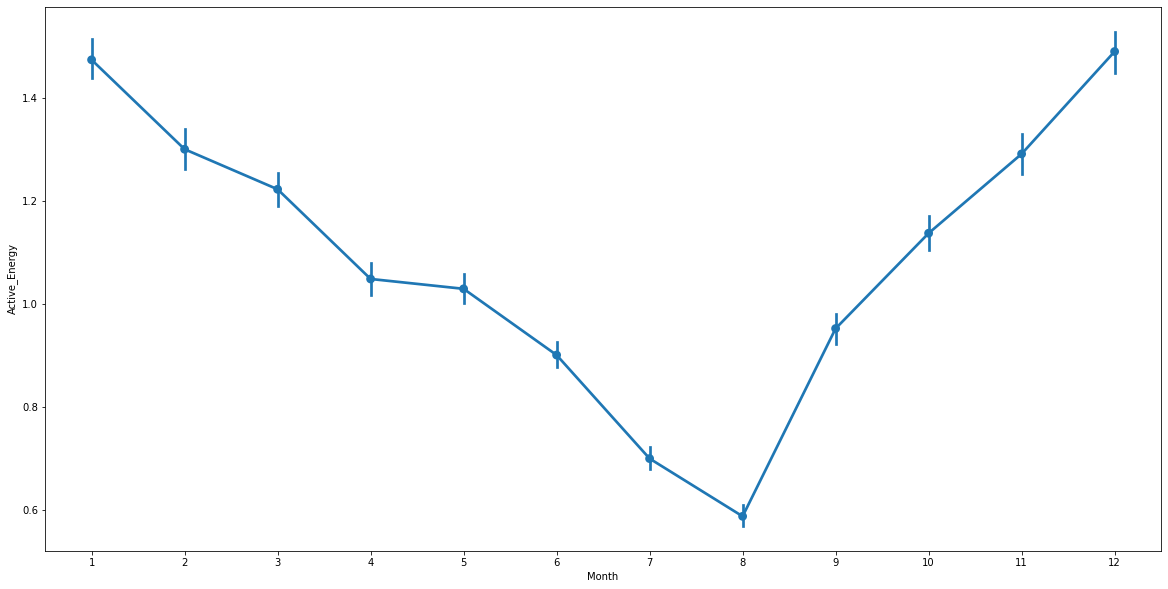

In [14]:
sns.pointplot(data=plot_for_power_consumption,x='Month',y='Active_Energy')

That plot reaffirm what we have previously seen, there is yearly pattern.

# Checking Stationarity

In [15]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

To say that a time series is stationarity, the time series must not change his statical properties (mean, variance, covariance) a long the time axis.
During the data visualitation we apreciate a clearly seasonal behaviour and the presence of seasonality makes the time series non-stationary.
But eye balling is not always reliable, for that reason we are going to check the stationarity applying statistical tests (ADFuller and 

In [16]:
def ADFuller(series, **kw):
    result = adfuller(series,autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')
    print(f'Result: The series is {"not " if result[1] > 0.05 else ""}stationary')

In [17]:
def kpss(series, **kw):
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

In [18]:
ADFuller(power_consumption['Active_Energy'])

ADF Statistic: -14.283024866475639
p-value: 1.3141026438731537e-26
Critial Values:
   1%, -3.4305393559398922
Critial Values:
   5%, -2.8616236906108443
Critial Values:
   10%, -2.566814545887977
Result: The series is stationary


In [ ]:
kpss(power_consumption['Active_Energy'])

As we can apreciate, something interesting is happening. The KPSS test, reafirmms but we had inferred from the EDA, the time series is not stationary. But the ADFuller reject the null hypothesis which indicates our series is stationary.
As a rule of thumb, when KPSS indicates non-stationarity and the ADF indicates stationarity, we can assume the series is difference stationary.

We will use the Box-Jenkins approach to make our series stationary. We will differenciate untill, we get a stationary time series.

In [ ]:
diff_1_series=power_consumption.copy()
data_for_reconstruction=diff_1_series[:1]
diff_1_series=diff_1_series.diff(1)
diff_1_series=diff_1_series.dropna()
diff_1_series.plot()

As we can see on the plot, after one diferentiation the series look stationary.

In [ ]:
decomposition = seasonal_decompose(diff_1_series['Active_Energy'], model='additive',period=8760, extrapolate_trend='freq')
decomposition.plot()
pyplot.show()

On the seasonal decompose, we can appreciate that trend has almost dissapear and that we still have a important seasonal component.

We run the statistical test again.

In [ ]:
ADFuller(diff_1_series['Active_Energy'])

In [ ]:
kpps(diff_1_series['Active_Energy'])

<AxesSubplot:xlabel='datetime'>

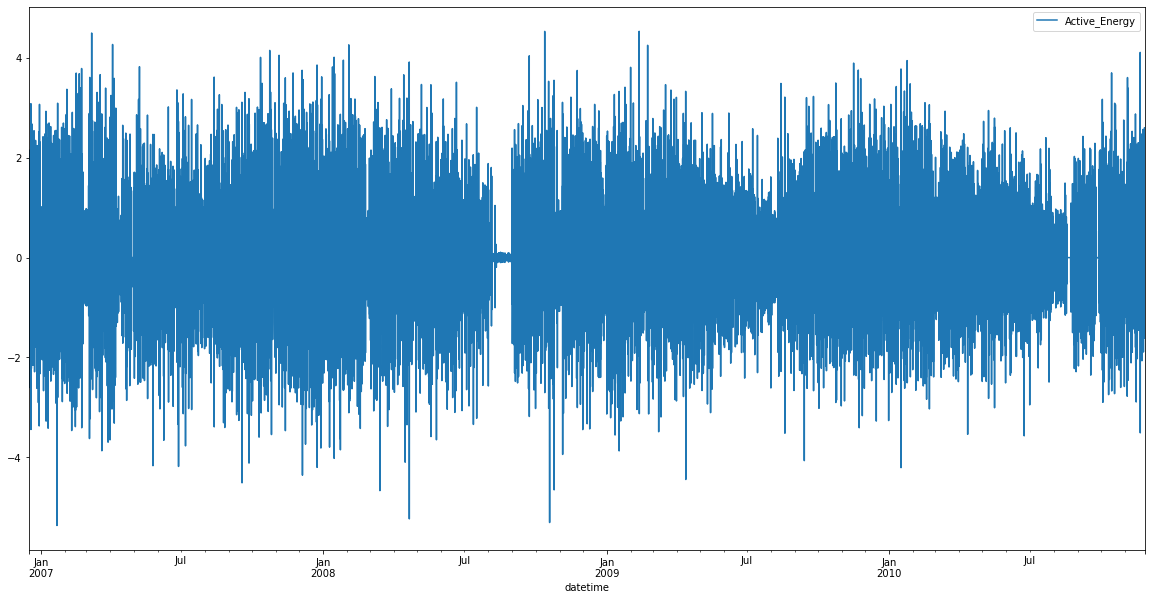

In [52]:
diff_2_series=power_consumption.copy()
data_for_reconstruction=diff_2_series[:2]
diff_2_series=diff_2_series.diff(2)
diff_2_series=diff_2_series.dropna()
diff_2_series.plot()

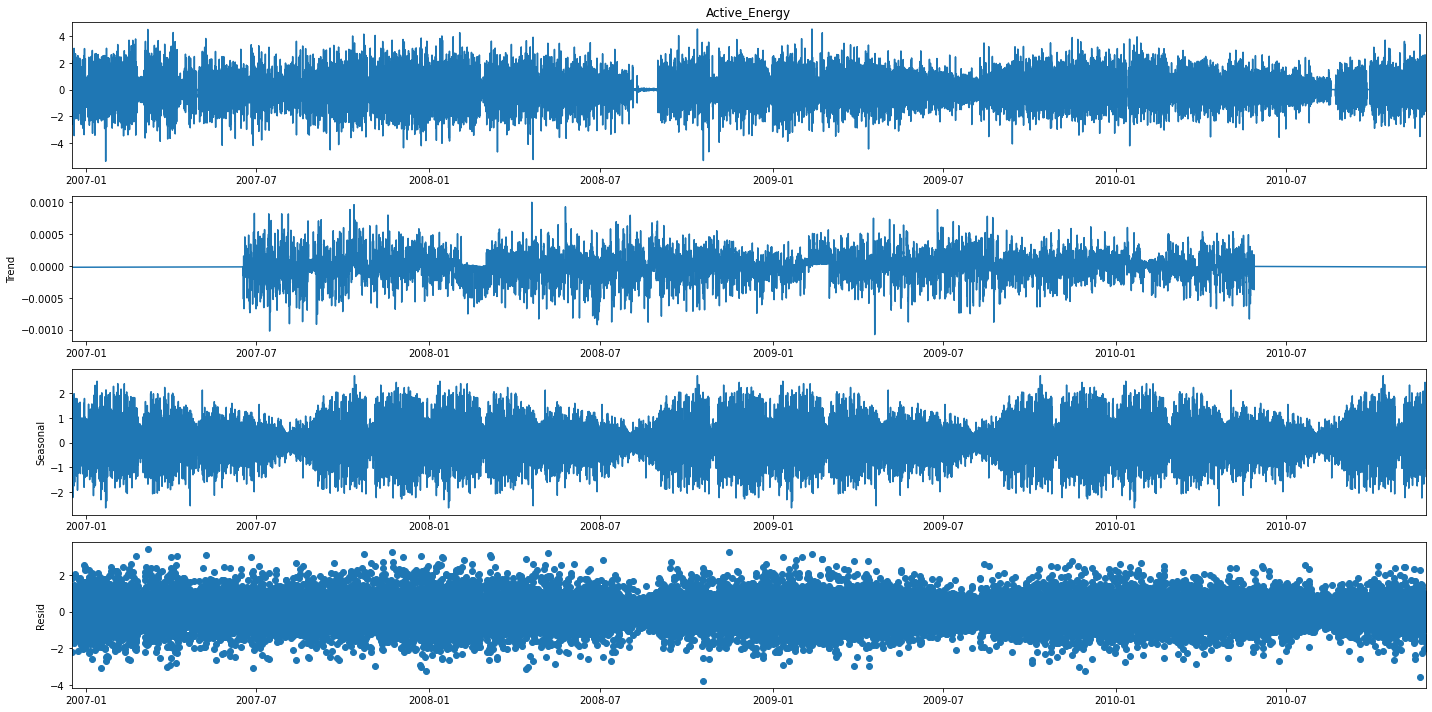

In [53]:
decomposition = seasonal_decompose(diff_2_series['Active_Energy'], model='additive',period=8760, extrapolate_trend='freq')
decomposition.plot()
pyplot.show()

We can see that more differenciation doesn't reduce the stationarity.